
# Coder un Réseau de neurones avec UNIQUEMENT Numpy
### Classification de chiffres écrits à la main

---


## Ce qu'on arrivera à faire : 

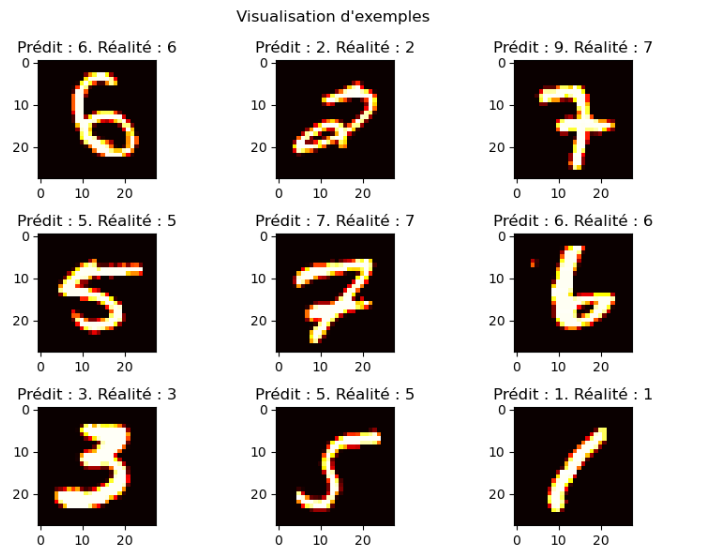

### Importation des données, normalisation

In [86]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


X, Y = fetch_openml('mnist_784', return_X_y=True, as_frame=False)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.6, random_state=1)

# Normalisation des données pour essayer d'éviter vanishing et exploding gradient
X_train = X_train.T / 255
X_test = X_test.T / 255
Y_train = Y_train.astype(np.int16)
Y_test = Y_test.astype(np.int16)

### Implémentation en classe de notre réseau

In [87]:
class MyNeuralNetwork:

    def __init__(self, layer_format):
        self.accuracies = []
        # Un array avec autant de valeurs de layers dans le réseau. Chaque valeur est le nombre de neurones sur ce layer
        self.layer_format = layer_format
        # -2 car on enlève le input layer et output layer
        self.hidden_layer_count = len(layer_format) - 2
        # Seuls les hiden layers ont des paramètres
        self.weights = [None] * self.hidden_layer_count
        self.biases = [None] * self.hidden_layer_count
        
        for i in range(self.hidden_layer_count):
            # On initialise les paramètres au hasard entre -0.5 et 0.5
            # Pour éviter une backpropagation où chaque neurone va dans le même sens
            # Et essayer de mitiger les problèmes de vanishing gradien et exploding gradient
            self.weights[i] = np.random.rand(self.layer_format[i+1], self.layer_format[i]) - 0.5
            self.biases[i] = np.random.rand(self.layer_format[i+1], 1) - 0.5
       
    
    def train(self, X, Y, alpha, epochs):
        for i in range(epochs + 1):
            # Forward prop nous donne toutes les valeurs des hidden layers
            As, Zs = self.forward_prop(X)
            # Backward prop nous donne les gradients (dénotés d...)
            dWeights, dBiases = self.backward_prop(As, Zs, X, Y)
            # On ajuste nos paramètres par rapports aux gradients calculés et notre taux d'apprentissage alpha
            self.update_params(dWeights, dBiases, alpha)
        
            if i % (epochs / 100) == 0:
                accuracy = self.accuracy(self.proba_to_predict(As[-1]), Y)
                accuracy = round(accuracy * 100, 2)
                self.accuracies.append(accuracy)
                if i % (epochs / 10) == 0:
                    print(f"Epoch #{i}. Accuracy : {accuracy}%.")
        print("------ Training Finished ------")

        
    def forward_prop(self, X):
        # As et Zs sont les valeurs des hidden layers sur l'ensemble des neurones,
        # respectivement après et avant fonction d'activation
        As, Zs = [], []
        
        # On boucle sur tous nos hidden layers
        for j in range(self.hidden_layer_count):
            
            # Si As est vide, c'est qu'on est au premier hidden layer : alors on utilise X, l'input, pour les calculs
            if len(As) == 0:
                temp_Z = np.dot(self.weights[j], X) + self.biases[j]
                temp_A = self.ReLU(temp_Z)
                
            # On est à l'avant dernier hidden layer : il est temps de transformer les valeurs de nos neurones en proba
            # On n'utilise alors pas ReLU comme fonction d'activation, mais softmax
            elif len(As) == self.hidden_layer_count - 1:
                temp_Z = np.dot(self.weights[j], As[-1])+ self.biases[j]
                temp_A = self.softmax(temp_Z)
                
            # Pour tous les autres layers, on calcule nos produits matriciels et applique la fonction d'activation ReLU.
            else:
                temp_Z = np.dot(self.weights[j], As[-1]) + self.biases[j]
                temp_A = self.ReLU(temp_Z)
                
            Zs.append(temp_Z)
            As.append(temp_A)
        return As, Zs

    def backward_prop(self, As, Zs, X, Y):
        m = Y.size
        # Encoded est décrit plus bas, c'est du one-hot-encoding
        encoded_Y = self.encode(Y)
        dWeights, dBiases = [], []

        for index in range(self.hidden_layer_count, 0, -1):
            
            # On est au dernier layer donc on compare avec les valeur à prédire, ie encoded_Y
            if index == self.hidden_layer_count:
                temp_dZ = As[-1] - encoded_Y
            else:
                temp_dZ = self.weights[index + 1 - 1].T.dot(previous_dZ) * self.d_ReLU(Zs[index-1])
            
            # On est au premier layer donc on prend l'input au lieu du layer précédent
            if index == 1:
                temp_dW = 1 / m * temp_dZ.dot(X.T)
            else:
                temp_dW = 1 / m * temp_dZ.dot(As[index-2].T)

            temp_dB = 1 / m * np.sum(temp_dZ, 1).reshape(-1, 1)
            
            # dWeights et dBiases contiennent dans l'ordre de la forward prop nos dérivées,
            # c'est plus facile ensuite pour mettre à jour les paramètres. d'ou le insert 0
            dWeights.insert(0, temp_dW)
            dBiases.insert(0, temp_dB)
            previous_dZ = temp_dZ
            
        return dWeights, dBiases

    def update_params(self, dWeights, dBiases, alpha):
        # On met à jours les paramètres du modèles en fonction de ceux existants, des gradients calculs et
        # du taux d'apprentissage alpha
        
        for j in range(self.hidden_layer_count):
            self.weights[j] = self.weights[j] - alpha * dWeights[j]
            self.biases[j] = self.biases[j] - alpha * dBiases[j]

    def proba_to_predict(self, A):
        # Argmax nous dit où se trouve le plus grand élément de A (qui est une proba)
        # et cet index est directement le chiffre prédit par le modèle
        return np.argmax(A, 0)

    def accuracy(self, predictions, Y):
        return np.sum(predictions == Y) / Y.size

    def encode(self, Y):
        # Sert à transformer Y, qui contient directement les classes à prédire (le chiffre),
        # en vecteur qui sera comparable à notre dernier hidden layer pour calculer le gradient
        # Ce dernier hidden layer contient 10 valeurs qui correspondent à la probabilité respective que notre input
        # soit tel ou tel chiffre.
        # Cet encodage permet d'obtenir un vecteur similaire, 10 valeurs, avec des 0 partout sauf à l'index du chiffre à prédire
        # Par exemple 3 => [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
        
        encoded = np.zeros((Y.size, Y.max() + 1))
        encoded[np.arange(Y.size), Y] = 1
        encoded = encoded.T
        return encoded

    def predict(self, samples):
        return self.proba_to_predict(self.forward_prop(samples)[-1][-1])

    # ------ Fonctions mathématiques ------
    def ReLU(self, Z):
        # Comparaison élément par élément, correspond à f:x -> x si >=0, 0 sinon
        return np.maximum(Z, 0)
    
    def softmax(self, Z):
        # Transforme un layer en probabilités
        Z = Z - Z.max(axis=0)
        A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
        return A

    def d_ReLU(self, Z):
        # Dérivée de ReLU. Fais la comparaison élément par élément. Si Z > 0, retourne true=1, la dérivée de f:x->x
        return Z > 0

### Entrainement d'un réseau avec 2 couches cachées de 16 et 10 neurones

In [88]:
model = MyNeuralNetwork([784, 16, 10, 1])
model.train(X_train, Y_train, epochs=700, alpha=0.1)

Epoch #0. Accuracy : 16.21%.
Epoch #70. Accuracy : 68.46%.
Epoch #140. Accuracy : 78.11%.
Epoch #210. Accuracy : 82.08%.
Epoch #280. Accuracy : 84.1%.
Epoch #350. Accuracy : 85.57%.
Epoch #420. Accuracy : 86.61%.
Epoch #490. Accuracy : 87.39%.
Epoch #560. Accuracy : 88.03%.
Epoch #630. Accuracy : 88.54%.
Epoch #700. Accuracy : 88.95%.
------ Training Finished ------


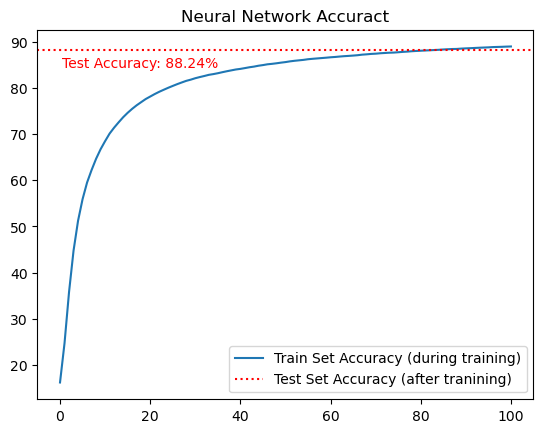

In [91]:
test_accuracy = model.accuracy(model.predict(X_test), Y_test) * 100
plt.plot(model.accuracies, label="Train Set Accuracy (during training)")
plt.axhline(y=test_accuracy, color='red', linestyle='dotted', label="Test Set Accuracy (after tranining)")
plt.text(35, test_accuracy - 3, f'Test Accuracy: {test_accuracy:.2f}%', color='red', va='center', ha='right')
plt.title("Neural Network Accuract")
plt.legend()

### Visualisation du résultat

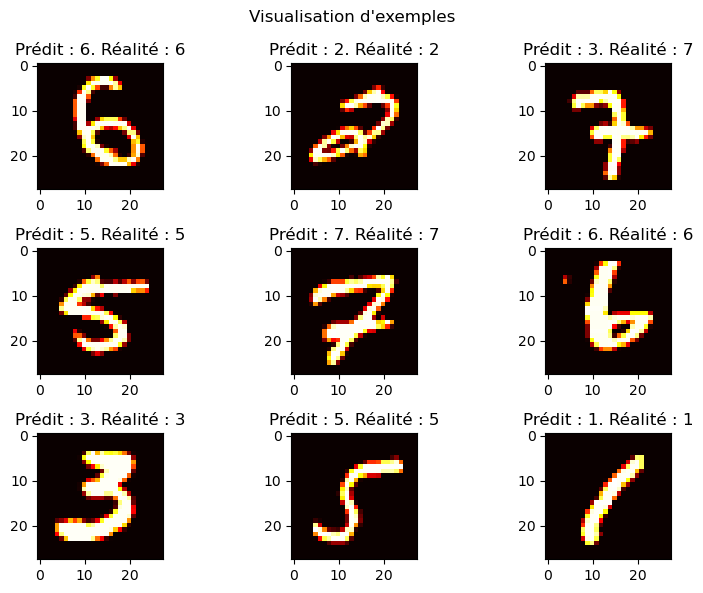

In [90]:
fig, axes = plt.subplots(3, 3, figsize=(8, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[:, i].reshape(28, 28), cmap="hot")
    ax.title.set_text(f"Prédit : {predictions[i]}. Réalité : {Y_test[i]}")
    
plt.suptitle("Visualisation d'exemples")
plt.tight_layout()

### Note

- Un réseau de neurones classique n'est pas le plus adapté pour ce genre de tâches, un CNN aurait été mieux.